In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import scanpy as sc
import torch
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Download Dataset and split into reference dataset and query dataset

In [4]:
adata = sc.read('pbmc_vars_sb.h5ad')

In [5]:
adata = adata[adata.obs['study']!='Villani'].copy()

In [6]:
adata.X = adata.layers["counts"].copy()

In [7]:
sca.add_annotations(adata, '../metadata/c2.cp.reactome.v4.0.symbols.gmt', min_genes=12)

In [8]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [9]:
sc.pp.normalize_total(adata)

In [10]:
sc.pp.log1p(adata)

In [11]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [12]:
select_terms = adata.varm['I'].sum(0)>12

In [13]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [14]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [15]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [16]:
adata.X = adata.layers["counts"].copy()

In [17]:
rm_terms = ['INTERFERON_SIGNALING', 'INTERFERON_ALPHA_BETA_SIGNALIN']

In [18]:
ix_f = []
for t in rm_terms:
    ix_f.append(adata.uns['terms'].index(t))

In [19]:
for i in ix_f:
    del adata.uns['terms'][i]

In [20]:
adata.varm['I'] = np.delete(adata.varm['I'], ix_f, axis=1)

In [21]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

### Create TRVAE model and train it on reference dataset

In [22]:
intr_cvae = sca.models.TRVAE(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[300, 300, 300],
    use_mmd=False,
    recon_loss='nb',
    mask=adata.varm['I'].T,
    use_decoder_relu=False,
    n_ext_decoder=0, # add additional unannotated terms in decoder
    n_expand_encoder=0, # same for encoder, should be the same number
    soft_mask=False, # use soft mask 
    use_hsic=False # use hsic
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 300 4
	Hidden Layer 1 in/out: 300 300
	Hidden Layer 2 in/out: 300 300
	Mean/Var Layer in/out: 300 280
Decoder Architecture:
	Cond layer in, ext, cond, out and :  280 0 4 1972
	with hard mask.


In [23]:
ALPHA = 0.7

In [24]:
OMEGA = None

In [25]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=200, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA, 
    omega=OMEGA,
    alpha_l1=None, # l1 reg parameter for soft mask
    gamma_ext=0.6, # l1 reg parameter on unannotated terms
    alpha_kl=0.5,
    beta=1., # hsic reg parameter
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    print_n_deactive=False,
    seed=2020
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |████████████--------| 63.0%  - epoch_loss:  875.32 - epoch_recon_loss:  846.88 - epoch_kl_loss:   56.88 - val_loss:  934.84 - val_recon_loss:  905.49 - val_kl_loss:   58.69
ADJUSTED LR
 |███████████████-----| 75.5%  - epoch_loss:  871.77 - epoch_recon_loss:  843.42 - epoch_kl_loss:   56.70 - val_loss:  936.48 - val_recon_loss:  907.39 - val_kl_loss:   58.17
ADJUSTED LR
 |████████████████----| 82.0%  - epoch_loss:  875.45 - epoch_recon_loss:  847.05 - epoch_kl_loss:   56.79 - val_loss:  936.32 - val_recon_loss:  907.33 - val_kl_loss:   57.98
ADJUSTED LR
 |██████████████████--| 92.0%  - epoch_loss:  873.96 - epoch_recon_loss:  845.59 - epoch_kl_loss:   56.75 - val_loss:  935.34 - val_recon_loss:  906.34 - val_kl_loss:   58.00
ADJUSTED LR
 |████████████████████| 100.0%  - epoch_loss:  872.89 - epoch_recon_loss:  844.61 - epoch_kl_loss:   56.57 - val_loss:  935.82 - val_recon_loss:  906.82 - val_kl_loss:   58.01
Saving best state of network...
Best State was in Epoch 191


In [26]:
inactive_idx = ~intr_cvae.model.decoder.nonzero_terms()

In [27]:
#ext_active = (intr_cvae.model.decoder.L0.ext_L.weight.data.abs() > 0).sum(0).cpu().numpy() > 12

In [28]:
#inactive_idx[-len(ext_active):] = ~ext_active

In [29]:
#adata.uns['terms'] += ['unannotated_' + str(i) for i in range(len(ext_active))]

In [30]:
print('Inactive terms:')
[term for i, term in enumerate(adata.uns['terms']) if inactive_idx[i]]

Inactive terms:


['PYRUVATE_METABOLISM_AND_CITRIC',
 'O_LINKED_GLYCOSYLATION_OF_MUCI',
 'SPHINGOLIPID_DE_NOVO_BIOSYNTHE',
 'RIP_MEDIATED_NFKB_ACTIVATION_V',
 'RORA_ACTIVATES_CIRCADIAN_EXPRE',
 'YAP1_AND_WWTR1_TAZ_STIMULATED_',
 'SMAD2_SMAD3_SMAD4_HETEROTRIMER',
 'DOWNREGULATION_OF_SMAD2_3_SMAD',
 'CHONDROITIN_SULFATE_DERMATAN_S',
 'LATENT_INFECTION_OF_HOMO_SAPIE',
 'SIGNALING_BY_FGFR_MUTANTS',
 'PHASE1_FUNCTIONALIZATION_OF_CO',
 'G1_PHASE',
 'RNA_POL_II_TRANSCRIPTION_PRE_I',
 'GLUCAGON_SIGNALING_IN_METABOLI',
 'FORMATION_OF_RNA_POL_II_ELONGA',
 'G_ALPHA_Z_SIGNALLING_EVENTS',
 'CD28_DEPENDENT_PI3K_AKT_SIGNAL',
 'CTLA4_INHIBITORY_SIGNALING',
 'SMOOTH_MUSCLE_CONTRACTION',
 'POST_NMDA_RECEPTOR_ACTIVATION_',
 'TAK1_ACTIVATES_NFKB_BY_PHOSPHO',
 'EFFECTS_OF_PIP2_HYDROLYSIS',
 'REGULATION_OF_SIGNALING_BY_CBL',
 'ION_TRANSPORT_BY_P_TYPE_ATPASE',
 'ION_CHANNEL_TRANSPORT',
 'PKB_MEDIATED_EVENTS',
 'ACTIVATION_OF_ATR_IN_RESPONSE_',
 'PACKAGING_OF_TELOMERE_ENDS',
 'CHOLESTEROL_BIOSYNTHESIS']

In [31]:
MEAN = False

In [32]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [33]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [34]:
sc.tl.umap(adata)

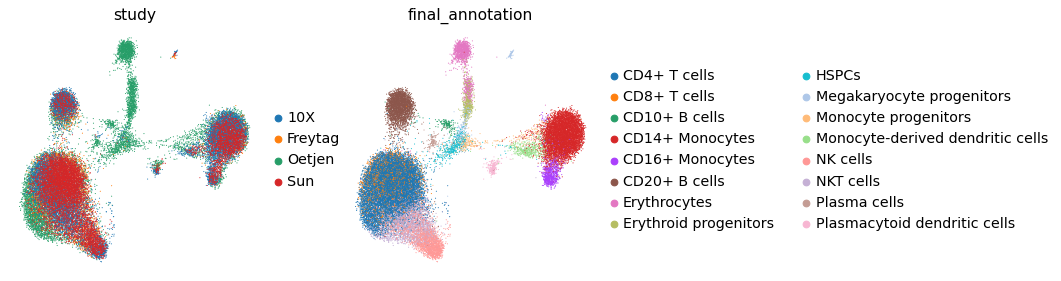

In [35]:
sc.pl.umap(adata, color=['study', 'final_annotation'], frameon=False)

In [36]:
#intr_cvae.save('intr_cvae_nb_mmd_beta_15')

In [37]:
kang = sc.read('kang_count.h5ad')[:, adata.var_names].copy()

In [38]:
kang.obs['study'] = 'Kang'

In [39]:
#q_intr_cvae = sca.models.TRVAE.load('q_intr_cvae_nb_alpha_kl_0_001_sd_2021', kang)

In [40]:
q_intr_cvae = sca.models.TRVAE.load_query_data(kang, intr_cvae,
                                               unfreeze_ext=True, # do not freeze the unannotated terms weights
                                               new_n_ext_decoder=2,
                                               new_n_expand_encoder=2)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 300 5
	Hidden Layer 1 in/out: 300 300
	Hidden Layer 2 in/out: 300 300
	Mean/Var Layer in/out: 300 280
	Expanded Mean/Var Layer in/out: 300 2
Decoder Architecture:
	Cond layer in, ext, cond, out and :  280 2 5 1972
	with hard mask.


In [41]:
q_intr_cvae.use_hsic_ = False
q_intr_cvae.model.use_hsic = False

In [42]:
q_intr_cvae.train(
    n_epochs=120, 
    alpha_epoch_anneal=50, 
    weight_decay=0., 
    alpha_kl=0.1,
    gamma_ext=0.70,
    beta=0,
    seed=2020,
    use_early_stopping=False,
    print_n_deactive=True
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Active genes in extension terms: [1954 1961]
Sparcity share in extension terms: [0.01 0.01]
 |--------------------| 0.8%  - epoch_loss: 1155.57 - epoch_recon_loss: 1155.57 - epoch_kl_loss:   58.50 - val_loss: 1058.13 - val_recon_loss: 1058.13 - val_kl_loss:   60.85Active genes in extension terms: [1918 1926]
Sparcity share in extension terms: [0.03 0.02]
 |--------------------| 1.7%  - epoch_loss:  938.41 - epoch_recon_loss:  938.29 - epoch_kl_loss:   64.11 - val_loss:  831.61 - val_recon_loss:  831.47 - val_kl_loss:   68.61Active genes in extension terms: [1782 1828]
Sparcity share in extension terms: [0.1  0.07]
 |--------------------| 2.5%  - epoch_loss:  738.87 - epoch_recon_loss:  738.57 - epoch_kl_loss:   75.87 - val_loss:  661.93 - val_recon_loss:  661.59 - val_kl_loss:   85.04Active genes in extension terms: [1573 1729]
Sparcity share in extension terms: [0.2  0.12]
 |--------------------| 3.3%  - epoch_loss:  618.84 - epoch_recon_loss:  618.25 - epoch_kl_loss:   99.29 - val_lo

In [43]:
ext_active = (q_intr_cvae.model.decoder.L0.ext_L.weight.data.abs() > 0).sum(0).cpu().numpy() > 30

In [44]:
inactive_idx = ~q_intr_cvae.model.decoder.nonzero_terms()

In [45]:
inactive_idx[-len(ext_active):] = ~ext_active

In [46]:
terms = adata.uns['terms'].copy()

In [47]:
terms += ['unannotated_' + str(i) for i in range(len(ext_active))]

In [631]:
#q_intr_cvae.save('q_intr_cvae_nolog_alpha_kl_0_5_0_1_sd_2020_rm5')

In [632]:
kang.obsm['X_cvae'] = q_intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [633]:
sc.pp.neighbors(kang, use_rep='X_cvae')

In [634]:
sc.tl.umap(kang)

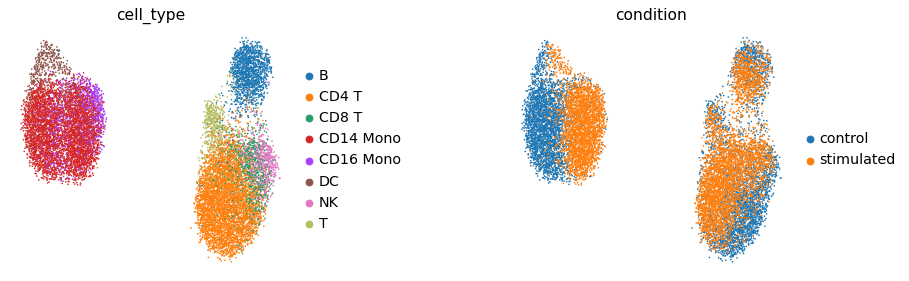

In [635]:
sc.pl.umap(kang, color=['cell_type', 'condition'], frameon=False, wspace=0.6)

In [48]:
ext_active

array([ True,  True])

In [53]:
# select unannotated term to plot
idx = [terms.index(term) for term in ['unannotated_0', 'SIGNALING_BY_THE_B_CELL_RECEPT']]

In [54]:
latents = q_intr_cvae.get_latent(mean=MEAN)[:, idx]

In [55]:
kang.obs['unannotated'] = latents[:, 0]
kang.obs['SIGNALING_BY_THE_B_CELL_RECEPT'] = latents[:, 1]

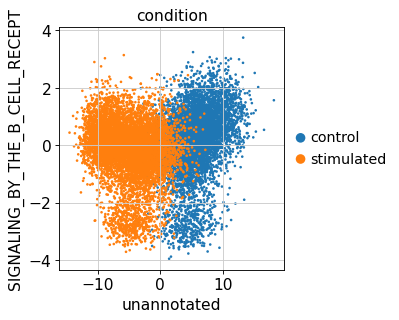

In [56]:
sc.pl.scatter(kang, x='unannotated', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='condition', size=22)

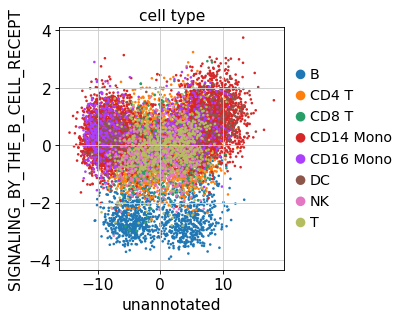

In [57]:
sc.pl.scatter(kang, x='unannotated', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='cell_type', size=22)

In [58]:
kang_pbmc = sc.AnnData.concatenate(adata, kang, batch_key='batch_join')

In [59]:
kang_pbmc.obsm['X_cvae'] = q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'].tolist(), mean=MEAN)[:, ~inactive_idx]

In [60]:
sc.pp.neighbors(kang_pbmc, use_rep='X_cvae')
sc.tl.umap(kang_pbmc)

In [61]:
kang_pbmc.strings_to_categoricals()

... storing 'batch' as categorical
... storing 'chemistry' as categorical
... storing 'data_type' as categorical
... storing 'final_annotation' as categorical
... storing 'sample_ID' as categorical
... storing 'species' as categorical
... storing 'study' as categorical
... storing 'tissue' as categorical
... storing 'orig.ident' as categorical
... storing 'stim' as categorical
... storing 'seurat_annotations' as categorical
... storing 'condition' as categorical
... storing 'cell_type' as categorical


In [62]:
kang_pbmc.obs['cell_type_joint'] = kang_pbmc.obs['final_annotation'].tolist()

In [63]:
idx_1 = kang_pbmc.obs['cell_type_joint'].astype(str) == 'nan'
idx_2 = kang_pbmc.obs['cell_type'].astype(str) != 'nan'
kang_pbmc.obs['cell_type_joint'][idx_1] = kang_pbmc.obs['cell_type'][idx_2].tolist()

In [64]:
categories = np.unique(kang_pbmc.obs['cell_type_joint'])

In [65]:
categories

array(['B', 'CD10+ B cells', 'CD14 Mono', 'CD14+ Monocytes', 'CD16 Mono',
       'CD16+ Monocytes', 'CD20+ B cells', 'CD4 T', 'CD4+ T cells',
       'CD8 T', 'CD8+ T cells', 'DC', 'Erythrocytes',
       'Erythroid progenitors', 'HSPCs', 'Megakaryocyte progenitors',
       'Monocyte progenitors', 'Monocyte-derived dendritic cells', 'NK',
       'NK cells', 'NKT cells', 'Plasma cells',
       'Plasmacytoid dendritic cells', 'T'], dtype=object)

In [66]:
celltypes_replace = {}
celltypes_replace['CD20+ B cells'] = 'B'
celltypes_replace['CD4 T'] = 'CD4+ T cells'
celltypes_replace['CD8 T'] = 'CD8+ T cells'
celltypes_replace['CD14 Mono'] = 'CD14+ Monocytes'
celltypes_replace['CD16 Mono'] = 'CD16+ Monocytes'
celltypes_replace['NK'] = 'NK cells'

In [67]:
for cat in categories:
    if cat in celltypes_replace:
        kang_pbmc.obs['cell_type_joint'][kang_pbmc.obs['cell_type_joint']==cat] = celltypes_replace[cat]

... storing 'cell_type_joint' as categorical


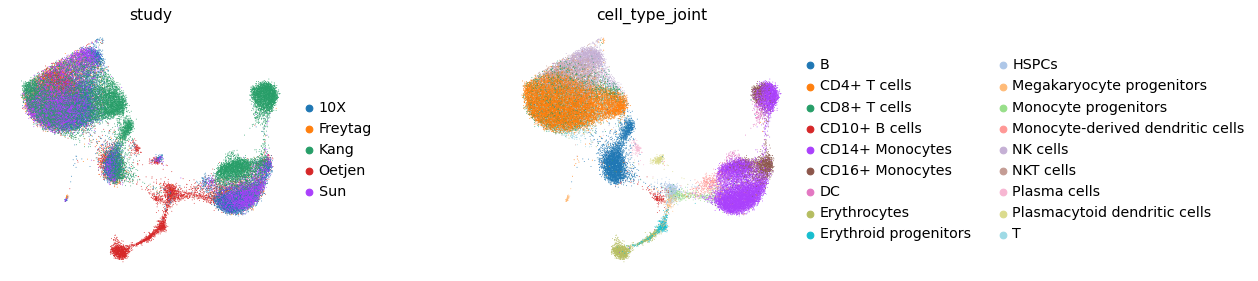

In [68]:
sc.pl.umap(kang_pbmc, color=['study', 'cell_type_joint'], frameon=False, wspace=0.6)

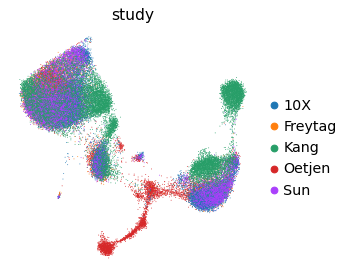

In [69]:
sc.pl.umap(kang_pbmc, color='study', frameon=False, wspace=0.6)

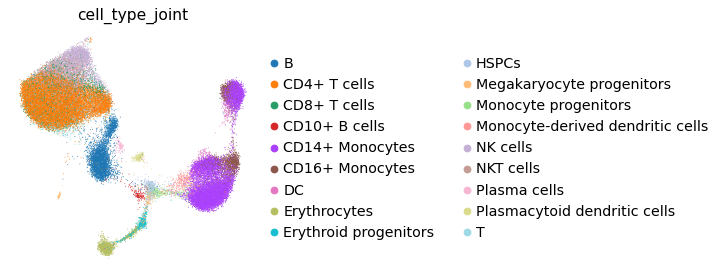

In [70]:
sc.pl.umap(kang_pbmc, color='cell_type_joint', frameon=False, wspace=0.6)

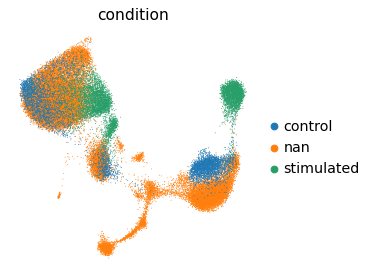

In [78]:
sc.pl.umap(kang_pbmc, color='condition', frameon=False, wspace=0.6)

In [79]:
kang_pbmc.uns['terms'] = adata.uns['terms']

In [80]:
#kang_pbmc.write('kang_pbmc_integrated_rm5.h5ad')

In [81]:
IFN_GENES = ['ADAR','ARIH1', 'B2M','CAMK2D', 'CD44','CIITA', 'DDX58', 'EGR1', 'EIF2AK2', 'EIF4A3',
             'EIF4E', 'EIF4E3', 'EIF4G3', 'FCGR1A', 'FCGR1B', 'GBP1', 'GBP2', 'GBP4', 'GBP5', 'HERC5', 
             'HLA-A', 'HLA-B', 'HLA-C', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQA2', 'HLA-DRB1', 
             'HLA-DRB5', 'HLA-F', 'HLA-G', 'ICAM1', 'IFI27', 'IFI35', 'IFI6', 'IFIT1', 'IFIT2', 'IFIT3', 
             'IFITM1', 'IFITM2', 'IFITM3', 'IFNAR1', 'IFNAR2', 'IFNG', 'IFNGR1', 'IFNGR2', 'IRF1', 'IRF2', 
             'IRF3', 'IRF4', 'IRF5', 'IRF7', 'IRF8', 'IRF9', 'ISG15', 'ISG20', 'JAK1', 'JAK2', 'KPNA1', 
             'KPNA2', 'MAPK3', 'MT2A', 'MX1', 'MX2', 'NCAM1', 'NUP205', 'NUP210', 'NUP214', 'NUP50', 
             'NUP88', 'NUPL2', 'OAS1', 'OAS2', 'OAS3', 'OASL', 'PIAS1', 'PLCG1', 'PML', 'PPM1B', 'PRKCD', 
             'PTAFR', 'PTPN1', 'PTPN6', 'RANBP2', 'SOCS1', 'SOCS3', 'STAT1', 'STAT2', 'TRIM25', 'TYK2',
             'UBA7', 'USP18', 'XAF1']

In [82]:
IFN_A_B_GENES = ['ISG15', 'IFI6', 'JAK1', 'GBP2', 'ADAR', 'STAT1', 'IRF2', 'IRF1', 'EGR1', 'IRF4', 
                 'HLA-F', 'HLA-G', 'HLA-A', 'HLA-C', 'HLA-B', 'IRF5', 'IFITM2', 'IFITM1', 'IFITM3', 
                 'IRF7', 'IFIT2', 'IFIT3', 'IFIT1', 'PTPN6', 'STAT2', 'OAS1', 'OAS3', 'OAS2', 'OASL',
                 'IRF9', 'IFI27', 'ISG20', 'SOCS1', 'IRF8', 'XAF1', 'IFI35', 'SOCS3', 'PTPN1', 'TYK2', 
                 'IRF3', 'USP18', 'IFNAR2', 'IFNAR1', 'MX2', 'MX1']

In [83]:
unann_idx = 0

In [84]:
import seaborn as sns

In [85]:
x=q_intr_cvae.model.decoder.L0.ext_L.weight.data.abs()[:, unann_idx].mean()

In [86]:
x = q_intr_cvae.model.decoder.L0.ext_L.weight.data.abs()[:, unann_idx].mean()

In [87]:
x

tensor(0.005, device='cuda:0')

<AxesSubplot:ylabel='Count'>

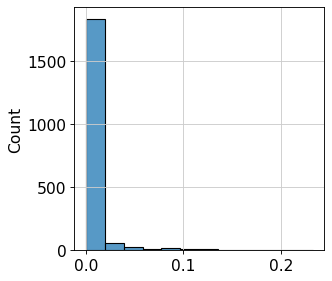

In [88]:
sns.histplot(q_intr_cvae.model.decoder.L0.ext_L.weight.data.abs()[:, unann_idx].cpu())

In [89]:
unann_genes = adata.var_names[(q_intr_cvae.model.decoder.L0.ext_L.weight.data.abs()[:, unann_idx]>x).cpu().numpy()].tolist()

In [90]:
len(unann_genes)

222

In [91]:
len(set(unann_genes).intersection(IFN_GENES))

38

In [92]:
len(set(unann_genes).intersection(IFN_A_B_GENES))

25

In [93]:
srt = np.argsort(q_intr_cvae.model.decoder.L0.ext_L.weight.data.abs()[:, unann_idx].cpu().numpy())[::-1]

In [94]:
unann_genes_top = adata.var_names[srt[:100]].tolist()

In [95]:
len(set(unann_genes_top).intersection(IFN_GENES))

32

In [96]:
len(set(unann_genes_top).intersection(IFN_A_B_GENES))

23

In [290]:
# check cxcl and other monocyte related, gpcr etc, metabolism